# LowLou PINN

In [ ]:
from setproctitle import setproctitle

setproctitle("LowLou PINN")

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

import numpy as np 
import matplotlib.pyplot as plt
import torch
import time

<matplotlib.image.AxesImage>

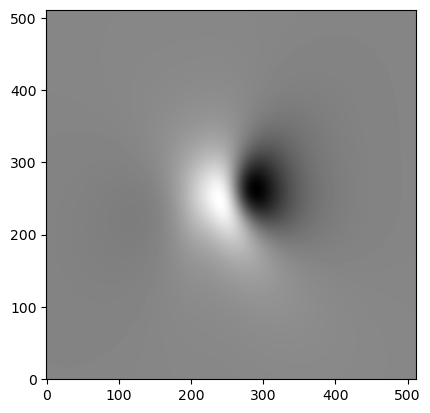

In [ ]:
input_path = '01_input/lowlou_512512512/'
bottom_npy_path = os.path.join(input_path, 'b_bottom.npy')

with open(bottom_npy_path, 'rb') as f:
        b_bottom = np.load(f)

plt.imshow(b_bottom[:, :, 2].transpose(), origin='lower', cmap='gray')

In [ ]:
output_path = '02_output/lowlou_512512512/PINN'
os.makedirs(output_path, exist_ok=True)

Nx, Ny, _ = b_bottom.shape
Nz = 512

spatial_norm = 32
b_norm = 100

In [ ]:
# boundary_path = os.path.join(output_path, 'boundary')
# os.makedirs(boundary_path, exist_ok=True)

# boundary_npy_path = os.path.join(boundary_path, 'boundary_data.npy')

In [ ]:
total_iterations = 10000
log_interval = 1000

num_neurons = 256
num_layers = 8

w_ff = 1
w_div = 1
w_bc_init = 1000
decay_iterations = 25000

lr_init = 5e-4
lr_final = 5e-5
lr_decay_iterations = 50000

batch_size = 10000
num_worker = 2

## cleanup

In [ ]:
from zpinn.create_pot import get_potential_boundary
from zpinn.pinn_nf2_cleanup import create_coordinates, NF2Trainer

### Create boundary data

In [ ]:
bottom_values = b_bottom.reshape(-1, 3)
bottom_bounds = (0, Nx-1, 0, Ny-1, 0, 0)
bottom_coords = create_coordinates(bottom_bounds).reshape(-1, 3)

coords, fields = get_potential_boundary(b_bottom[:, :, 2], Nz)

for i in range(len(coords)):
    coords[i] = np.reshape(coords[i], (-1, 3))
    fields[i] = np.reshape(fields[i], (-1, 3))

top_lateral_values = np.concatenate(fields) 
top_lateral_coords = np.concatenate(coords)

boundary_values = np.concatenate([top_lateral_values, bottom_values])
boundary_coords = np.concatenate([top_lateral_coords, bottom_coords])

normalized_boundary_values = boundary_values / b_norm
normalized_boundary_coords = boundary_coords / spatial_norm

boundary_data = np.stack([normalized_boundary_coords, normalized_boundary_values], 1)

with open(boundary_npy_path, 'wb') as f:
        np.save(f, boundary_data)

Potential Field:  35%|███▍      | 167/480 [00:07<00:14, 21.85it/s]


KeyboardInterrupt: 

### PINN

In [ ]:
torch.set_num_threads(num_worker)

In [ ]:
with open(boundary_npy_path, 'rb') as f:
        boundary_data = np.load(f)

In [ ]:
trainer = NF2Trainer(output_path, b_bottom, height=Nz, b_norm=b_norm, spatial_norm=spatial_norm, meta_info=None, boundary_data=boundary_data)

In [ ]:
trainer.setup(total_iterations=total_iterations, batch_size=batch_size, log_interval=log_interval, num_workers=num_worker,
              num_neurons=num_neurons, num_layers=num_layers, w_ff=w_ff, w_div=w_div, w_bc_init=w_bc_init, decay_iterations=decay_iterations,
              lr_init=lr_init, lr_final=lr_final, lr_decay_iterations=lr_decay_iterations)

In [ ]:
start = time.time()

trainer.train()

runtime = time.time() - start
print(f'Runtime --> total: {runtime:.2f}sec')

Training:   0%|          | 1/10000 [00:02<5:47:21,  2.08s/it]

[Iteration 000000/010000] [loss: 46.02579117] [loss_bc: 46.02577209; loss_div: 0.00001164; loss_ff: 0.00000649] [w_bc: 1000.000000, LR: 0.000500]


Training:   0%|          | 15/10000 [00:20<3:46:52,  1.36s/it]


KeyboardInterrupt: 

In [ ]:
with open(os.path.join(output_path, 'losses.npy'), "rb") as f:
        losses = np.load(f)

Text(0, 0.5, 'Loss')

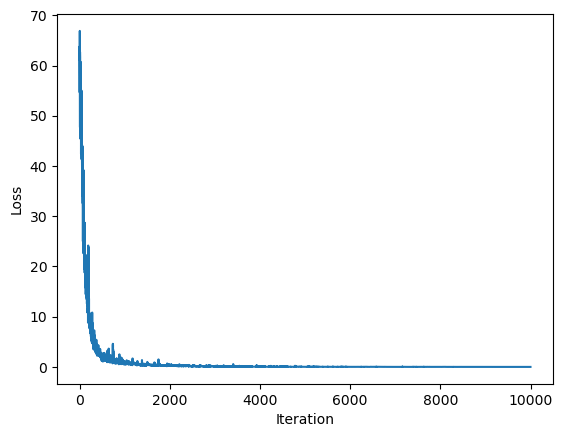

In [ ]:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')

In [ ]:
with open(os.path.join(output_path, 'losses_no_weight.npy'), "rb") as f:
        losses_no_weight = np.load(f)

Text(0, 0.5, 'Loss (no weight)')

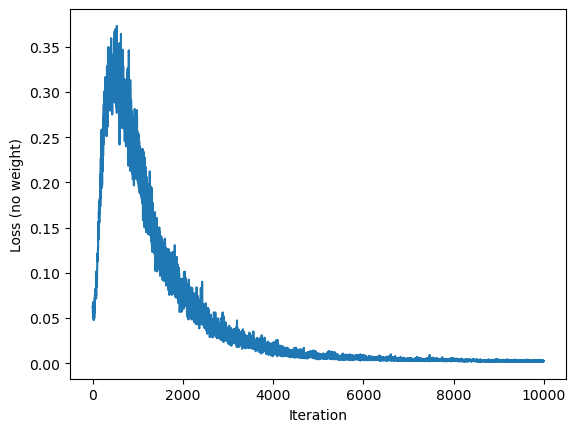

In [ ]:
plt.plot(losses_no_weight)
plt.xlabel('Iteration')
plt.ylabel('Loss (no weight)')

## PINN

In [ ]:
from zpinn.pinn_nf2_old import NF2Trainer

In [ ]:
trainer = NF2Trainer(output_path, b_bottom, Nz, spatial_norm, b_norm,
                     meta_info=None, dim=num_neurons,
                     positional_encoding=False,
                     use_potential_boundary=True, w_div=w_div, w_ff=w_ff,
                     decay_iterations=decay_iterations, meta_path=None,
                     use_vector_potential=False, work_directory=None)

Potential Boundary: 100%|██████████| 15/15 [00:02<00:00,  6.68it/s]


In [ ]:
start = time.time()

trainer.train(total_iterations, batch_size, log_interval, log_interval, num_workers=num_worker)

runtime = time.time() - start
print(f'Runtime --> total: {runtime:.2f}sec ({(runtime/(total_iterations-1)*1000):.2f}ms/iter.)')

Training:   0%|          | 3/10000 [00:01<1:12:39,  2.29it/s]

[Iteration 000000/010000] [loss: 203.48573303] [loss_bc: 203.48571777; loss_div: 0.00001220; loss_ff: 0.00000713] [w_bc: 1000.000000, LR: 0.000500]


Training:  10%|█         | 1001/10000 [01:13<11:37, 12.90it/s]

[Iteration 001000/010000] [loss: 0.57753992] [loss_bc: 0.48332256; loss_div: 0.04272874; loss_ff: 0.05148862] [w_bc: 758.787207, LR: 0.000397]


Training:  10%|█         | 1012/10000 [01:14<11:03, 13.54it/s]


KeyboardInterrupt: 

In [ ]:
with open(os.path.join(output_path, 'losses.npy'), "rb") as f:
        losses = np.load(f)

Text(0, 0.5, 'Loss')

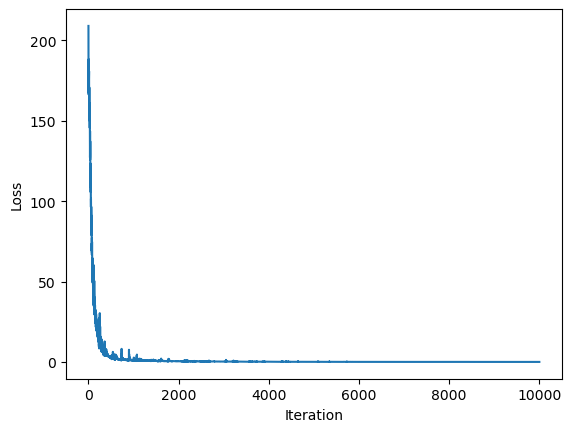

In [ ]:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')

In [ ]:
with open(os.path.join(output_path, 'losses_no_weight.npy'), "rb") as f:
        losses_no_weight = np.load(f)

Text(0, 0.5, 'Loss (no weight)')

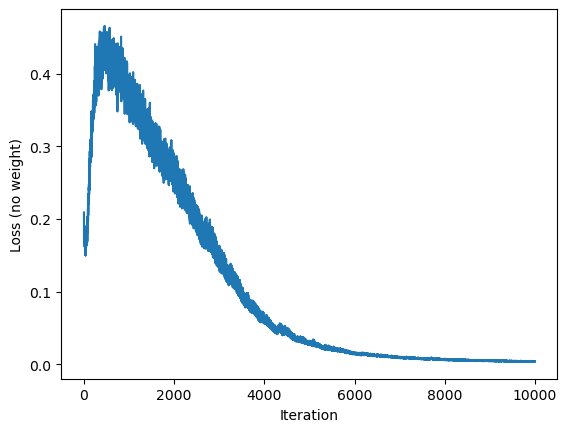

In [ ]:
plt.plot(losses_no_weight)
plt.xlabel('Iteration')
plt.ylabel('Loss (no weight)')

## Viz

In [ ]:
import pyvista as pv
from zpinn.pinn_nf2_visualization import pinn_cube, draw_grid

In [ ]:
pv.start_xvfb()
pv.global_theme.trame.server_proxy_enabled = True
pv.set_jupyter_backend('static')

In [ ]:
eval_path = '03_eval/lowlou_512512512/PINN'
os.makedirs(eval_path, exist_ok=True)


### vtk

In [ ]:
epo = 1000
save_path = os.path.join(output_path, 'model_%06d.pt' % epo)
pinn = pinn_cube(save_path)
pinn.calculate_magnetic_fields(batch_size=batch_size)

100%|██████████| 13422/13422 [00:28<00:00, 477.95it/s]


NameError: name 'eval_path' is not defined

In [ ]:
vtk_paths = os.path.join(eval_path, f'B_pinn_{epo}.vtk')
pinn.grid.save(vtk_paths)

In [ ]:
iterations = np.arange(0, total_iterations+1, log_interval)

for epo in iterations:
    save_path = os.path.join(output_path, 'model_%06d.pt' % epo)
    pinn = pinn_cube(save_path)
    pinn.calculate_magnetic_fields(batch_size=batch_size)
    vtk_paths = os.path.join(eval_path, f'B_pinn_{epo}.vtk')
    pinn.grid.save(vtk_paths)

100%|██████████| 1678/1678 [00:03<00:00, 490.29it/s]


In [ ]:
# save_path = os.path.join(output_path, 'model_%06d.pt' % total_iterations)
# pinn = pinn_cube(save_path)
# pinn.calculate_magnetic_fields(batch_size=batch_size)

100%|██████████| 210/210 [00:01<00:00, 162.90it/s]


ImageData (0x7fc0a592d3c0)
  N Cells:      2048383
  N Points:     2097152
  X Bounds:     0.000e+00, 1.270e+02
  Y Bounds:     0.000e+00, 1.270e+02
  Z Bounds:     0.000e+00, 1.270e+02
  Dimensions:   128, 128, 128
  Spacing:      1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:     2

In [ ]:
# pinn.state

{'iteration': 2000,
 'model': DataParallel(
   (module): BModel(
     (d_in): Linear(in_features=3, out_features=256, bias=True)
     (linear_layers): ModuleList(
       (0-7): 8 x Linear(in_features=256, out_features=256, bias=True)
     )
     (d_out): Linear(in_features=256, out_features=3, bias=True)
   )
 ),
 'cube_shape': (128, 128, 128),
 'b_norm': 100,
 'spatial_norm': 32,
 'loss_bc': array(0.00067845, dtype=float32),
 'w_bc': 575.4399373371799,
 'loss_div': array(0.10612815, dtype=float32),
 'w_div': 1,
 'loss_ff': array(0.10184613, dtype=float32),
 'w_ff': 1,
 'LR': 0.0004560054196779496}

In [ ]:
# pinn.grid.save(vtk_path)

### load

In [ ]:
vtk_path = os.path.join(eval_path, f'B_pinn_{1000}.vtk')

In [ ]:
vtk_path = os.path.join(eval_path, f'B_pinn_{total_iterations}.vtk')

In [ ]:
B_pinn_mesh = pv.read(vtk_path)

In [ ]:
B_pinn_grid = draw_grid(B_pinn_mesh)

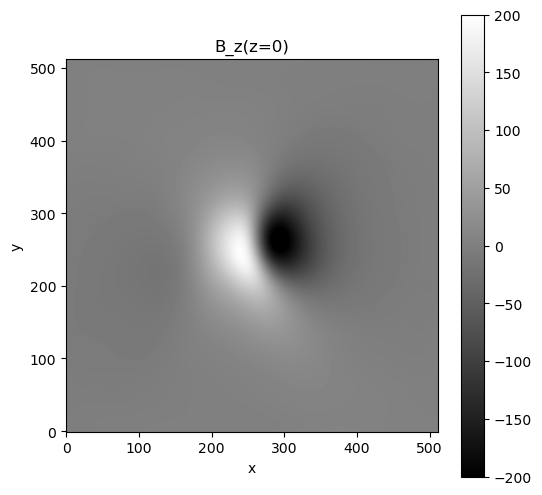

In [ ]:
B_pinn_grid.plt_Bz_imshow(z=0, vmin=-200, vmax=200)

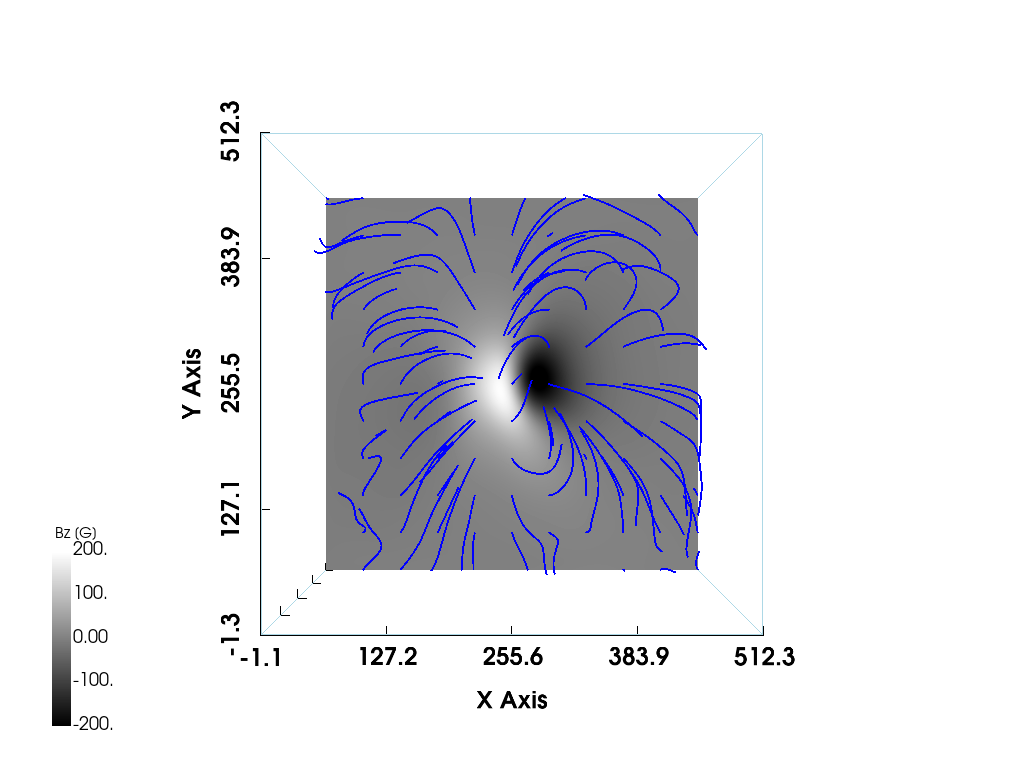

In [ ]:
B_pinn_grid.pv_streamline_Bz(camera_position='xy', i_resolution=10, j_resolution=10, vmin=-200, vmax=200)